Synchronization
===============

In this tutorial we will demonstrate how to synchronize two Qblox instruments using the SYNQ technology (see section 
[Synchronization](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/synchronization.html)).
For this tutorial we will use one QCM and one QRM and we will be acquiring waveforms sequenced by the QCM using the QRM. 
By synchronizing the two instruments using the SYNQ technology, timing the acquisition of the waveforms becomes trivial.

If we are using a Pulsar QCM and QRM we need to connect both instruments to the same network, connect the $\text{REF}^{out}$ of the QCM to the 
$\text{REF}^{in}$ of the QRM using a 50cm coaxial cable, connect their SYNQ ports using the SYNQ cable and finally connect $\text{O}^{[1-2]}$ of the QCM to $\text{I}^{[1-2]}$ of the QRM respectively.

The Cluster QCM and QRM are internally connected for SYNQ capability and therefore no new need connections need to be made if one is using a Cluster.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable –-py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect_qcm = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select QCM",
)
connect_qrm = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select QRM",
)
connect_cluster = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Cluster",
)

#### Pulsar <a id='pulsar_setup'></a>
Select the Pulsar QCM and QRM modules by running the following cell. Skip to the [Cluster section](#cluster_setup) if you are using a Cluster.

In [ ]:
display(connect_qcm)
display(connect_qrm)

In [ ]:
# Close existing connections to Pulsar
Pulsar.close_all()

# Retrieve device name and IP address and Connect
# QCM
qcm_device_name = connect_qcm.value
qcm_device_number = connect_qcm.options.index(qcm_device_name)
qcm_ip_address = device_list[device_keys[qcm_device_number]]["identity"]["ip"]
qcm = Pulsar(f"{qcm_device_name}", qcm_ip_address)
qcm.reset()  # reset QCM
print(f"{qcm_device_name} connected at {qcm_ip_address}")
print(qcm.get_system_state())

# QRM
qrm_device_name = connect_qrm.value
qrm_device_number = connect_qrm.options.index(qrm_device_name)
qrm_ip_address = device_list[device_keys[qrm_device_number]]["identity"]["ip"]
qrm = Pulsar(f"{qrm_device_name}", qrm_ip_address)
qrm.reset()  # reset QRM
print(f"{qrm_device_name} connected at {qrm_ip_address}")
print(qrm.get_system_state())

In [5]:
# Set reference clock source.
qrm.reference_source("external")

Skip to the next section [(Generate Waveform)](#gen_wf) if you are not using a cluster. 

#### Cluster <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar section](#pulsar_setup) if you are using a Pulsar.


In [2]:
display(connect_cluster)

Dropdown(description='Select Cluster', options=('cluster-mm',), value='cluster-mm')

In [3]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect_cluster.value
device_number = connect_cluster.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster
cluster = Cluster(device_name, ip_address)
print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.0.2


We then find all available cluster modules to connect to them individually.

In [5]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

connect_qcm = widgets.Dropdown(
    options=[key for key in available_slots.keys()], description="Select QCM"
)
connect_qrm = widgets.Dropdown(
    options=[key for key in available_slots.keys()], description="Select QRM"
)

cluster-mm connected at 192.168.1.0



Select the QCM and QRM module from the available modules in your Cluster.


In [6]:
print(available_slots)
print()
display(connect_qcm)
display(connect_qrm)

{'module2': 'QCM', 'module4': 'QRM'}


Dropdown(description='Select QCM', options=('module2', 'module4'), value='module2')

Dropdown(description='Select QRM', options=('module2', 'module4'), value='module2')

Finally, we connect to the selected Cluster modules. 

In [7]:
# Connect to QCM and QRM
qcm = getattr(
    cluster, connect_qcm.value
)  # Connect to the module that you have chosen above
print(f"{available_slots[connect_qcm.value]} connected")


qrm = getattr(cluster, connect_qrm.value)
print(f"{available_slots[connect_qrm.value]} connected")
print(cluster.get_system_state())

QCM connected
QCM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


Generate waveforms<a id='gen_wf'></a>
------------------

Next, we need to create the waveforms for the sequence.

In [6]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_length) * i)
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
}

Let's plot the waveforms to see what we have created.

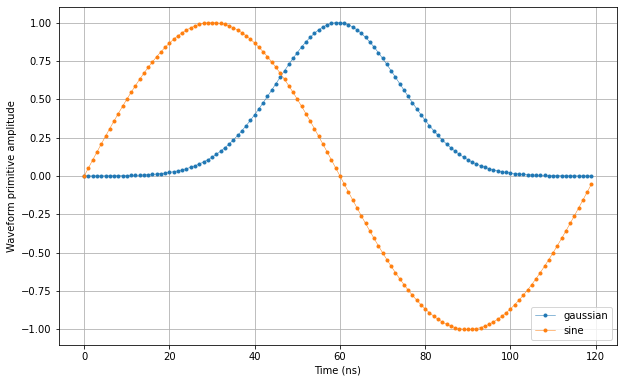

In [7]:
time = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create one acquisition specification that creates a single bin. However, we will not be using the bin in this turorial.

In [8]:
# Acquisitions
acquisitions = {"measurement": {"num_bins": 1, "index": 0}}

Create Q1ASM programs
---------------------

Now that we have the waveforms and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms in the QCM and
acquires the waveforms in the QRM.

In [9]:
# QCM sequence program.
qcm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
play      0,1,16384 #Play waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

# QRM sequence program.
qrm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
acquire   0,0,16384 #Acquire waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

Upload sequences
----------------

Now that we have the waveforms and Q1ASM programs, we can combine them in the sequences stored in JSON files.

In [10]:
# Add QCM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qcm_seq_prog,
}
with open("qcm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Add QRM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_seq_prog,
}
with open("qrm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 of both QCM and QRM, which will drive outputs $\text{O}^{[1-2]}$
of the QCM and acquire on inputs $\text{I}^{[1-2]}$ of the QRM.

In [11]:
# Upload waveforms and programs to QCM.
qcm.sequencer0.sequence("qcm_sequence.json")

# Upload waveforms and programs to QRM.
qrm.sequencer0.sequence("qrm_sequence.json")

Play sequences
--------------

The sequence has been uploaded to the instruments. Now we need to configure the sequencers of both the QCM and QRM to use the `wait_sync` instruction
to synchronize and we need to configure the sequencer of the QRM to trigger the acquisition with the `acquire` instruction.
Furthermore we also need to attenuate the QCM's outputs to 40% to be able to capture the full range of the waveforms on the QRM's inputs.

$\text{Attenuation}={Input}/{Output}={2V}/{5V}={0.4}$

In [12]:
# Configure the sequencer of the QCM.
qcm.sequencer0.sync_en(True)
qcm.sequencer0.gain_awg_path0(0.35)  # Adding a bit of margin to the 0.4
qcm.sequencer0.gain_awg_path1(0.35)

# Map sequencer of the QCM to specific outputs (but first disable all sequencer connections)
for sequencer in qcm.sequencers:
    for out in range(0, 2):
        sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)
qcm.sequencer0.channel_map_path0_out0_en(True)
qcm.sequencer0.channel_map_path1_out1_en(True)

# Configure the scope acquisition of the QRM.
qrm.scope_acq_sequencer_select(0)
qrm.scope_acq_trigger_mode_path0("sequencer")
qrm.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer of the QRM.
qrm.sequencer0.sync_en(True)

Now let's start the sequences.

In [13]:
# Arm and start sequencer of the QCM (only sequencer 0).
qcm.arm_sequencer(0)
qcm.start_sequencer()

# Print status of sequencer of the QCM.
print("QCM status:")
print(qcm.get_sequencer_state(0))
print()

# Arm and start sequencer of the QRM (only sequencer 0).
qrm.arm_sequencer(0)
qrm.start_sequencer()

# Print status of sequencer of the QRM.
print("QRM status:")
print(qrm.get_sequencer_state(0))

QCM status:
Status: Q1_STOPPED, Flags: NONE

QRM status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs by both instruments. And as you might have noticed, timing these operations was simplified
significantly by the SYNQ technology. Lets retrieve the resulting data, but first let's make sure the sequencers have finished.

In [14]:
# Wait for the QCM sequencer to stop with a timeout period of one minute.
qcm.get_sequencer_state(0, 1)

# Wait for the QRM acquisition to finish with a timeout period of one minute.
qrm.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
qrm.store_scope_acquisition(0, "measurement")

# Get acquisition list from instrument.
acq = qrm.get_acquisitions(0)

Let's plot the result.

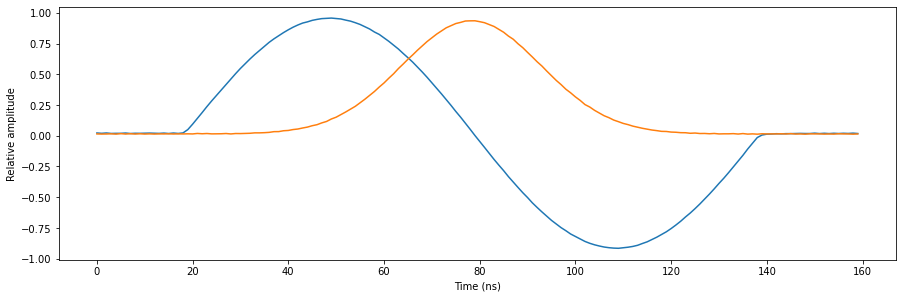

In [15]:
# Plot acquired signal on both inputs.
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(acq["measurement"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(acq["measurement"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
matplotlib.pyplot.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop sequencers.
qcm.stop_sequencer()
qrm.stop_sequencer()

# Print status of sequencers.
print("QCM:")
print(qcm.get_sequencer_state(0))
print()

print("QRM:")
print(qrm.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of instrument parameters.
# print("QCM snapshot:")
# qcm.print_readable_snapshot(update=True)
# print()

# print("QRM snapshot:")
# qrm.print_readable_snapshot(update=True)

# Close the instrument connections.
Pulsar.close_all()
Cluster.close_all()